In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
import joblib
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.utils.multiclass import type_of_target
from sklearn.utils import check_X_y
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RepeatedStratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

%run './python/Chicago_Car_Crashes.py'

## DATA COLLECTION

In [103]:
crashes = pd.read_csv('./data/Traffic_Crashes_-_Crashes.csv.gz', index_col=0)
print(f"{'Dataset contains shape'}\n{'Rows':10}{crashes.shape[0]}\n{'Columns':10}{crashes.shape[1]}")

Dataset contains shape
Rows      490128
Columns   49


In [4]:
crashes.CRASH_DATE = pd.to_datetime(crashes.CRASH_DATE)
df = crashes[(crashes.CRASH_DATE.dt.year == 2020)].drop('Unnamed: 0', axis=1).copy()
df.to_csv('./data/Chicago_Traffic_Crashes_2020.csv.gz',index=False, compression='gzip')

In [2]:
df = pd.read_csv('./data/Chicago_Traffic_Crashes_2020.csv.gz', low_memory=False)

####  DESCRIPTIVE STATISTICS

In [3]:
df.head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,...,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,2020-07-10 10:25:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,...,0.0,0.0,3.0,0.0,10,6,7,41.773456,-87.585022,POINT (-87.585022352022 41.773455972008)
1,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,2020-07-11 01:00:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,...,0.0,0.0,3.0,0.0,1,7,7,41.802119,-87.622115,POINT (-87.622114914961 41.802118543011)
2,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,2020-07-08 14:00:00,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,14,4,7,NaN,NaN,NaN
3,f636d4a51a88015ac89031159b1f1952b8d92e49d11aeb...,JD293237,NaN,2020-07-10 22:20:00,30,NO CONTROLS,NO CONTROLS,CLEAR,"DARKNESS, LIGHTED ROAD",SIDESWIPE OPPOSITE DIRECTION,...,1.0,0.0,1.0,0.0,22,6,7,41.880386,-87.725807,POINT (-87.725807044026 41.880385884998)
4,76aabcf7c2219a5c90259c96fe94b33834ddb53e0dbcd3...,JD291826,NaN,2020-07-09 17:06:00,10,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,...,0.0,0.0,1.0,0.0,17,5,7,NaN,NaN,NaN


In [4]:
df.describe()

,POSTED_SPEED_LIMIT,LANE_CNT,STREET_NO,BEAT_OF_OCCURRENCE,NUM_UNITS,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE
count,92092.000000,12.000000,92092.000000,92092.000000,92092.00000,91858.000000,91858.000000,91858.000000,91858.000000,91858.00000,91858.000000,91858.0,92092.000000,92092.000000,92092.000000,91504.000000,91504.000000
mean,28.532793,2.250000,3860.405985,1216.832732,2.04831,0.215060,0.001698,0.024407,0.124714,0.06424,1.949563,0.0,13.411730,4.150513,6.533076,41.847012,-87.675642
std,5.761715,0.965307,2905.455298,697.276831,0.50948,0.600362,0.044480,0.182377,0.458035,0.32037,1.123697,0.0,5.635321,1.992724,3.469571,0.290151,0.582834
min,0.000000,1.000000,0.000000,111.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,-87.934763
25%,30.000000,2.000000,1401.000000,633.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.0,10.000000,2.000000,3.000000,41.773154,-87.723524
50%,30.000000,2.000000,3407.000000,1121.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,0.0,14.000000,4.000000,7.000000,41.865686,-87.676296
75%,30.000000,2.250000,5749.000000,1731.000000,2.00000,0.000000,0.000000,0.000000,0.000000,0.00000,2.000000,0.0,17.000000,6.000000,9.000000,41.917273,-87.633251
max,70.000000,4.000000,13799.000000,6100.000000,15.00000,19.000000,3.000000,6.000000,18.000000,11.00000,37.000000,0.0,23.000000,7.000000,12.000000,42.022780,0.000000


## DATA SCRUBBING

prima di inziare ad esplorare i dati dobbiamo individuare le variable da escludere in particolare quelli con i dati mancanti e quelli che hanno poca rilevanza per il nostro modello.


In [5]:
dfi = Dframe(df)

In [6]:
dfi.df_info()

Data Entries                       92092
Data Columns                       49
DataFrame items                    4,512,508
DataFrame Null                     948953  Null values
DataFrame contain                  21.03% Null Values 

 #   Column                        Null Count &  Percent   Dtype
---  ------                        ---------------------   -------
0    CRASH_RECORD_ID               0                   0.00    % object
1    RD_NO                         0                   0.00    % object
2    CRASH_DATE_EST_I              85,157              92.47   % object
3    CRASH_DATE                    0                   0.00    % object
4    POSTED_SPEED_LIMIT            0                   0.00    % int64
5    TRAFFIC_CONTROL_DEVICE        0                   0.00    % object
6    DEVICE_CONDITION              0                   0.00    % object
7    WEATHER_CONDITION             0                   0.00    % object
8    LIGHTING_CONDITION            0                   0.0

In [7]:
to_drop_cols    = set()
excluded_cols   = set()
category_cols   = set()
numeric_cols    = set()
encoding_cols   = set()
features_cols   = set()
statistic_cols  = set()

In [8]:
excluded_cols.update([
    'Unnamed: 0','Unnamed: 0.1','CRASH_RECORD_ID','RD_NO','CRASH_DATE_EST_I','LANE_CNT',
    'REPORT_TYPE','DAMAGE','PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','LOCATION',
    'WORK_ZONE_TYPE', 'BEAT_OF_OCCURRENCE', 'DATE_POLICE_NOTIFIED', 'CRASH_TYPE', 'SEC_CONTRIBUTORY_CAUSE'])
# df.drop(labels=cols_to_drop, axis=1, inplace=True)

In [9]:
TransformerDate = DateTransformer()
df.CRASH_DATE =  TransformerDate.fit_transform(df.CRASH_DATE)

In [10]:
ImputerCat_with_Unknown  = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='unknown')
df.loc[:,dfi.NaN_obj_colmns] = ImputerCat_with_Unknown.fit_transform(df.loc[:,dfi.NaN_obj_colmns] )

In [11]:
ImputerMostFrequent = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
df.loc[:,dfi.NaN_num_columns] = ImputerMostFrequent.fit_transform(df.loc[:,dfi.NaN_num_columns])

## FEATURES ENGINEERING

#### POSTED_SPEED_LIMIT

Acceleration is a major cause of car accidents, which is why we consider it a very important factor for our model.

unfortunately the information provided in the dataset relating to the variable "POSTED_SPEED_LIMIT" is somewhat confused and anomalous for this reason we refer to the official Illinois statute section Vehicle Code no. (625 ILCS 5 /) as a reliable source to sort our data as appropriately as possible.

    70 mph - Rural interstates and tollways.
    65 mph - Highways with four lanes.
    55 mph - Other highways and rural areas.
    45 mph - Urban freeways and interstates through downtown Chicago.
    30 mph - Urban Districts - City/Town Areas.
    20 mph - School Zones (on school days between 7 a.m. and 4 p.m.
    15 mph - Urban Alleys.

For more info: [Illinois Compiled Statutes](https://www.ilga.gov/legislation/ilcs/ilcs4.asp?DocName=062500050HCh%2E+11+Art%2E+IX&ActID=1815&ChapterID=49&SeqStart=122500000&SeqEnd=123600000)

In [12]:
df.POSTED_SPEED_LIMIT.unique()

array([30, 20, 10, 15, 25, 35, 55, 45,  5, 50,  0, 40, 39, 65,  1, 34,  3,
       12, 60,  9, 26, 33, 49, 70, 11, 36, 32, 24,  2, 14, 31, 29])

In [13]:
TransformSpeed = SpeedTransformer()
df['POSTED_SPEED_LIMIT'] = TransformSpeed.fit_transform(df['POSTED_SPEED_LIMIT'])

In [14]:
df.POSTED_SPEED_LIMIT.sort_values().unique()

array(['15', '20', '30', '45', '55', '65', '70'], dtype=object)

## PRIM CONTRIBUTORY CAUSE

In [15]:
df.PRIM_CONTRIBUTORY_CAUSE.unique()

array(['FAILING TO YIELD RIGHT-OF-WAY', 'UNABLE TO DETERMINE',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'IMPROPER BACKING', 'IMPROPER OVERTAKING/PASSING',
       'IMPROPER LANE USAGE', 'DISREGARDING TRAFFIC SIGNALS',
       'NOT APPLICABLE', 'IMPROPER TURNING/NO SIGNAL',
       'FOLLOWING TOO CLOSELY', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'ROAD CONSTRUCTION/MAINTENANCE', 'WEATHER',
       'PHYSICAL CONDITION OF DRIVER',
       'FAILING TO REDUCE SPEED TO AVOID CRASH',
       'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
       'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)',
       'DISTRACTION - FROM INSIDE VEHICLE',
       'DRIVING ON WRONG SIDE/WRONG WAY',
       'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)',
       'EQUIPMENT - VEHICLE CONDITION', 'DISREGARDING STOP SIGN',
       'TEXTING', 'DISTRACTION - FROM OUTSIDE VEHICLE',
       'DISREGARDING YIELD SIGN', 'CELL PHONE USE OTHER THAN TEXTING',
 

In [17]:
df.PRIM_CONTRIBUTORY_CAUSE = df.PRIM_CONTRIBUTORY_CAUSE.apply(target_grouper)

In [18]:
df.PRIM_CONTRIBUTORY_CAUSE.unique()

array(['IMPROPER_MANEUVER', 'UNABLE TO DETERMINE',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'DISREGARDING', 'NOT APPLICABLE',
       'DRIVING_SKILLS/KNOWLEDGE/EXPERIENCE', 'ROAD_CONDITION', 'WEATHER',
       'PHYSICAL CONDITION OF DRIVER', 'ANIMAL', 'ALCOHOL_DRUGS',
       'DISTRACTION', 'EQUIPMENT - VEHICLE CONDITION',
       'RELATED TO BUS STOP', 'PASSING STOPPED SCHOOL BUS',
       'BICYCLE ADVANCING LEGALLY ON RED LIGHT',
       'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT'], dtype=object)

In [15]:
df[sorted(set(df.columns)-excluded_cols)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92092 entries, 0 to 92091
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   ALIGNMENT                      92092 non-null  object        
 1   CRASH_DATE                     92092 non-null  datetime64[ns]
 2   CRASH_DAY_OF_WEEK              92092 non-null  int64         
 3   CRASH_HOUR                     92092 non-null  int64         
 4   CRASH_MONTH                    92092 non-null  int64         
 5   DEVICE_CONDITION               92092 non-null  object        
 6   DOORING_I                      92092 non-null  object        
 7   FIRST_CRASH_TYPE               92092 non-null  object        
 8   HIT_AND_RUN_I                  92092 non-null  object        
 9   INJURIES_FATAL                 92092 non-null  float64       
 10  INJURIES_INCAPACITATING        92092 non-null  float64       
 11  INJURIES_NON_IN

In [16]:
statistic_cols.update(['CRASH_DATE','CRASH_DAY_OF_WEEK','CRASH_HOUR','CRASH_MONTH', 'DOORING_I',
                       'HIT_AND_RUN_I','INJURIES_FATAL','INJURIES_INCAPACITATING',
                       'INJURIES_NON_INCAPACITATING','INJURIES_NO_INDICATION','INJURIES_REPORTED_NOT_EVIDENT',
                       'INJURIES_TOTAL','INJURIES_UNKNOWN','LATITUDE','LONGITUDE','MOST_SEVERE_INJURY',
                       'NUM_UNITS','STREET_DIRECTION','STREET_NAME','STREET_NO'])

In [17]:
features_cols.update(set(df.columns)-excluded_cols.union(statistic_cols))

In [18]:
df[sorted(features_cols)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92092 entries, 0 to 92091
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ALIGNMENT                92092 non-null  object
 1   DEVICE_CONDITION         92092 non-null  object
 2   FIRST_CRASH_TYPE         92092 non-null  object
 3   INTERSECTION_RELATED_I   92092 non-null  object
 4   LIGHTING_CONDITION       92092 non-null  object
 5   NOT_RIGHT_OF_WAY_I       92092 non-null  object
 6   POSTED_SPEED_LIMIT       92092 non-null  object
 7   PRIM_CONTRIBUTORY_CAUSE  92092 non-null  object
 8   ROADWAY_SURFACE_COND     92092 non-null  object
 9   ROAD_DEFECT              92092 non-null  object
 10  TRAFFICWAY_TYPE          92092 non-null  object
 11  TRAFFIC_CONTROL_DEVICE   92092 non-null  object
 12  WEATHER_CONDITION        92092 non-null  object
 13  WORKERS_PRESENT_I        92092 non-null  object
 14  WORK_ZONE_I              92092 non-nul

## EXPLORATORY DATA ANALYSIS


## CRASH TYPE

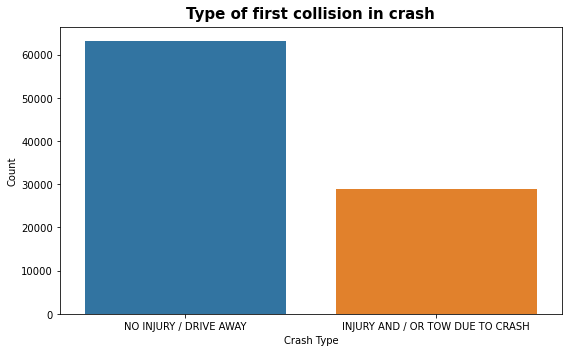

In [19]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(x=df.CRASH_TYPE, ax=ax)
ax.set_title("Type of first collision in crash", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Crash Type')
ax.set_ylabel('Count')
plt.savefig('./img/crach_type.jpg',format="jpg")
plt.show()

## ESTIMATED DAMAGE

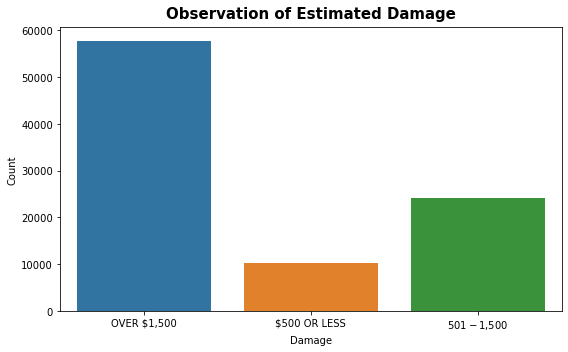

In [122]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(x=df.DAMAGE, ax=ax)
ax.set_title("Observation of Estimated Damage", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Damage')
ax.set_ylabel('Count')
plt.savefig('./img/damage.jpg',format="jpg")
plt.show()

## MOST SEVERE INGURY

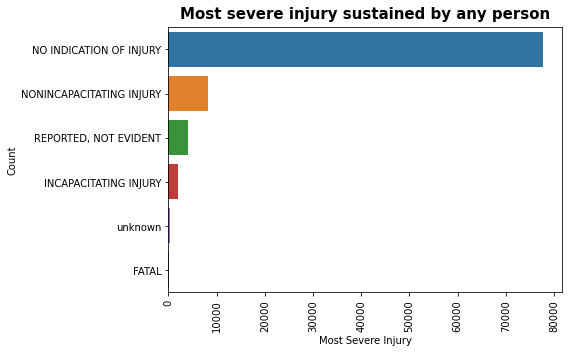

In [20]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=df.MOST_SEVERE_INJURY.value_counts().values, y= df.MOST_SEVERE_INJURY.value_counts().index, ax=ax)
ax.set_title("Most severe injury sustained by any person", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Most Severe Injury')
ax.set_ylabel('Count')
plt.xticks(rotation=90)
plt.savefig('./img/Most_Severe_Injury.jpg',format="jpg")
plt.show()

## WEATHER CONDITION

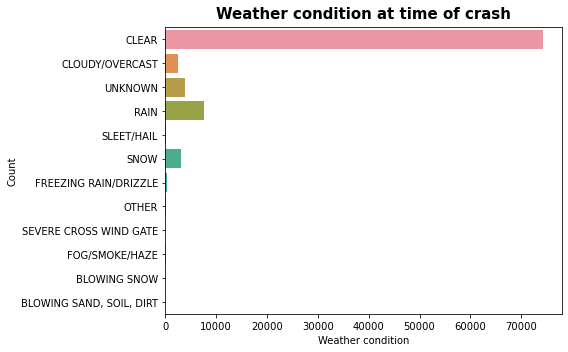

In [124]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(y=df.WEATHER_CONDITION, data=df, ax=ax)
ax.set_title("Weather condition at time of crash", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Weather condition')
ax.set_ylabel('Count')
plt.savefig('./img/Weathercondition.jpg',format="jpg")
plt.show()

## ROAD SURFACE CONDITION

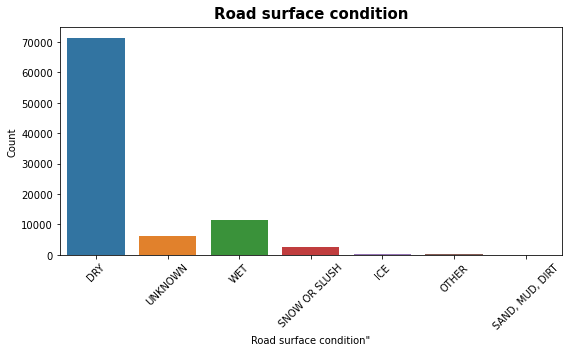

In [125]:
fig, ax = plt.subplots(figsize=(8,5))
sns_crach_type = sns.countplot(x=df.ROADWAY_SURFACE_COND, ax=ax)
ax.set_title("Road surface condition", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Road surface condition"')
ax.set_ylabel('Count')
plt.xticks(rotation=45)
plt.savefig('./img/road_surface_condition.jpg',format="jpg")
plt.show()

<H1>Posted Speed Limit Analysis<H/>

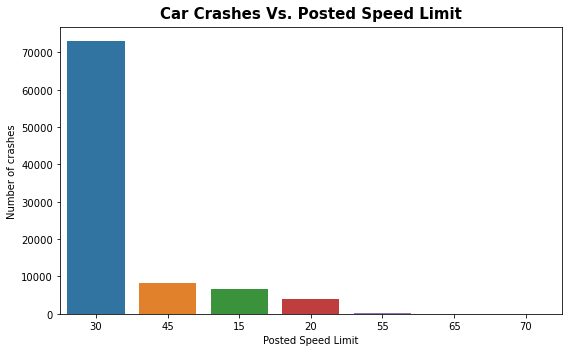

In [22]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x=df.POSTED_SPEED_LIMIT.value_counts().index, y=df.POSTED_SPEED_LIMIT.value_counts(), ax=ax)
ax.set_title("Car Crashes Vs. Posted Speed Limit", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Posted Speed Limit')
ax.set_ylabel('Number of crashes')
plt.savefig('./img/speed_number_of_crashes.jpg',format="jpg")
plt.show()

## Speed Limit by Number of units-related

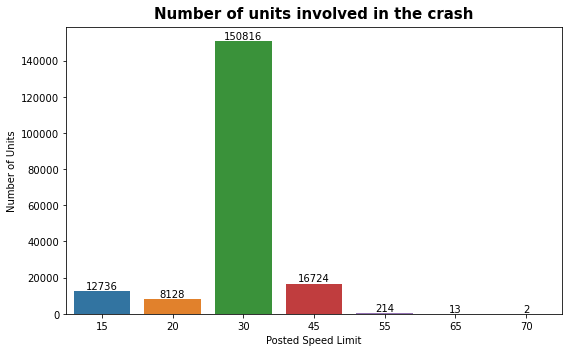

In [127]:
speed_unit = df.groupby('POSTED_SPEED_LIMIT', as_index=False).agg({'NUM_UNITS': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_speed_unit=sns.barplot(x='POSTED_SPEED_LIMIT', y='NUM_UNITS', data=speed_unit, ax=ax)
for index, row in speed_unit.iterrows():
    sns_speed_unit.text(x=row.name,
                        y=row.NUM_UNITS,
                        s=round(row.NUM_UNITS),
                        color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("Number of units involved in the crash", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Posted Speed Limit')
ax.set_ylabel('Number of Units')
plt.savefig('./img/speed_unit.jpg',format="jpg")
plt.show()

## INJURIES ANALYSIS

## Number of injuries by Speed Limit-related

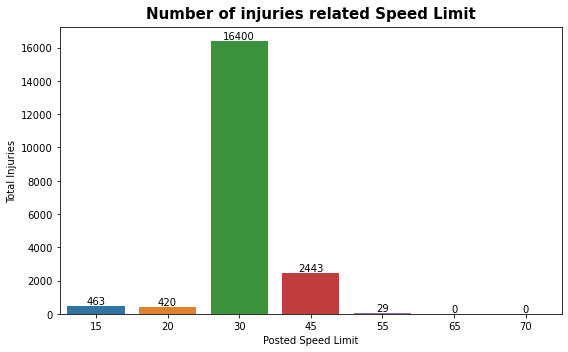

In [128]:
speed_injuries = df.groupby('POSTED_SPEED_LIMIT', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_speed_injured=sns.barplot(x='POSTED_SPEED_LIMIT', y='INJURIES_TOTAL', data=speed_injuries, ax=ax)
for index, row in speed_injuries.iterrows():
    sns_speed_injured.text(x=row.name,
                           y=row.INJURIES_TOTAL,
                           s=round(row.INJURIES_TOTAL),
                           color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("Number of injuries related Speed Limit", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Posted Speed Limit')
ax.set_ylabel('Total Injuries')
plt.savefig('./img/speed_injures.jpg',format="jpg")
plt.show()

## Number of injuries by Month-related

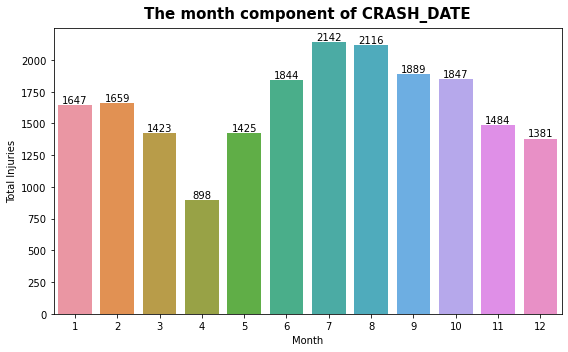

In [129]:
injuries_month = df.groupby('CRASH_MONTH', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_injuries_month=sns.barplot(x='CRASH_MONTH', y='INJURIES_TOTAL', data=injuries_month, ax=ax)
for index, row in injuries_month.iterrows():
    sns_injuries_month.text(x=row.name,
                            y=row.INJURIES_TOTAL,
                            s=round(row.INJURIES_TOTAL),
                            color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("The month component of CRASH_DATE", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Month')
ax.set_ylabel('Total Injuries')
plt.savefig('./img/injuries_month.jpg',format="jpg")
plt.show()

##  Number of injuries by Day of Week-related

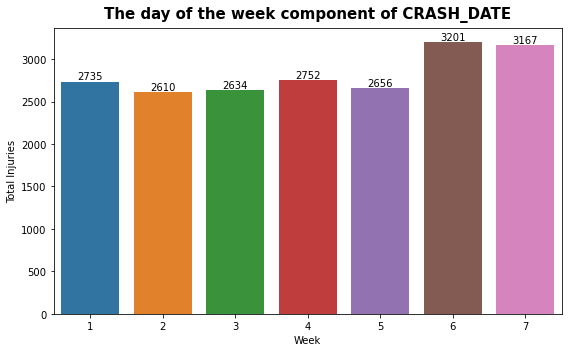

In [130]:
injuries_week = df.groupby('CRASH_DAY_OF_WEEK', as_index=False).agg({'INJURIES_TOTAL': 'sum'})
fig, ax = plt.subplots(figsize=(8,5))
sns_injuries_week=sns.barplot(x='CRASH_DAY_OF_WEEK', y='INJURIES_TOTAL', data=injuries_week, ax=ax)
for index, row in injuries_week.iterrows():
    sns_injuries_week.text(x=row.name,
                           y=row.INJURIES_TOTAL,
                           s=round(row.INJURIES_TOTAL),
                           color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("The day of the week component of CRASH_DATE", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Week')
ax.set_ylabel('Total Injuries')
plt.savefig('./img/injuries_week.jpg',format="jpg")
plt.show()

##  Number of injuries by Hour-related

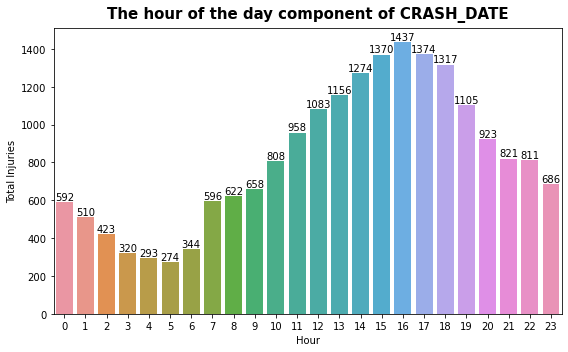

In [131]:
injuries_hour = df.groupby('CRASH_HOUR', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_injuries_hour=sns.barplot(x='CRASH_HOUR', y='INJURIES_TOTAL', data=injuries_hour, ax=ax)

for index, row in injuries_hour.iterrows():
    sns_injuries_hour.text(x=row.name,
                           y=row.INJURIES_TOTAL,
                           s=round(row.INJURIES_TOTAL),
                           color='black', va='bottom',  ha="center", fontsize=10)
ax.set_title("The hour of the day component of CRASH_DATE", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Hour')
ax.set_ylabel('Total Injuries')
plt.savefig('./img/injuries_hour.jpg',format="jpg")
plt.show()

## Number of injuries by Roadway Condition-related

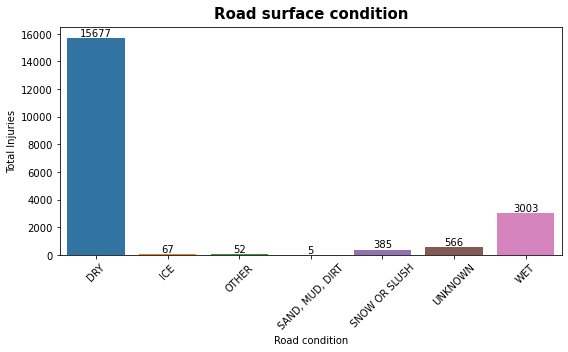

In [132]:
injuries_road = df.groupby('ROADWAY_SURFACE_COND', as_index=False).agg({'INJURIES_TOTAL': 'sum'})

fig, ax = plt.subplots(figsize=(8,5))
sns_injuries_road=sns.barplot(x='ROADWAY_SURFACE_COND', y='INJURIES_TOTAL', data=injuries_road, ax=ax)

for index, row in injuries_road.iterrows():
    sns_injuries_road.text(x=row.name,
                           y=row.INJURIES_TOTAL,
                           s=round(row.INJURIES_TOTAL),
                           color='black', va='bottom', ha="center", fontsize=10)
    sns.barplot(x='ROADWAY_SURFACE_COND', y='INJURIES_TOTAL', data=injuries_road, ax=ax)
plt.xticks(rotation=45)
ax.set_title("Road surface condition", fontsize=15, weight='bold', ha='center', va='bottom')
ax.set_xlabel('Road condition')
ax.set_ylabel('Total Injuries')
plt.savefig('./img/Road_surface_condition.jpg', format="jpg")
plt.show()

## PREPROCESSING

In [133]:
df_features = df[sorted(features_cols)].copy()

In [134]:
df_features_info = Dframe(df_features)

In [135]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92092 entries, 0 to 92091
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   ALIGNMENT                92092 non-null  object
 1   DEVICE_CONDITION         92092 non-null  object
 2   FIRST_CRASH_TYPE         92092 non-null  object
 3   INTERSECTION_RELATED_I   92092 non-null  object
 4   LIGHTING_CONDITION       92092 non-null  object
 5   NOT_RIGHT_OF_WAY_I       92092 non-null  object
 6   POSTED_SPEED_LIMIT       92092 non-null  object
 7   PRIM_CONTRIBUTORY_CAUSE  92092 non-null  object
 8   ROADWAY_SURFACE_COND     92092 non-null  object
 9   ROAD_DEFECT              92092 non-null  object
 10  TRAFFICWAY_TYPE          92092 non-null  object
 11  TRAFFIC_CONTROL_DEVICE   92092 non-null  object
 12  WEATHER_CONDITION        92092 non-null  object
 13  WORKERS_PRESENT_I        92092 non-null  object
 14  WORK_ZONE_I              92092 non-nul

In [136]:
category_cols.update(('TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION',
                    'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
                     'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I','WORK_ZONE_I', 'WORKERS_PRESENT_I'))

## Features Transformation using OneHotEncoder

In [137]:
ohe_features = OneHotEncoder(sparse=False, drop='first')
ohe_features.fit(df_features[category_cols])

df_features_ohe = pd.concat([df_features.drop(labels=category_cols, axis=1),
                             pd.DataFrame(ohe_features.transform(df_features[category_cols]),
                                          columns=ohe_features.get_feature_names(list(category_cols)))],
                            axis=1)
df_features_ohe.drop(labels=['PRIM_CONTRIBUTORY_CAUSE'], axis=1, inplace=True)

## Target Transformation using OneHotEncoder

In [138]:
ohe_target     = OneHotEncoder(handle_unknown='ignore', sparse=False)
df_target_ohe  = pd.DataFrame(ohe_target.fit_transform(df_features.PRIM_CONTRIBUTORY_CAUSE.values.reshape(-1,1)),
                         columns=ohe_target.categories_)
df_target_ohe.columns = df_target_ohe.columns.get_level_values(0).str.replace(' ', '_')

In [139]:
lc_prim_contributory_cause =  LabelEncoder()
df_target_encoded = pd.DataFrame(lc_prim_contributory_cause.fit_transform(df_features['PRIM_CONTRIBUTORY_CAUSE']),
                                columns=['PRIM_CONTRIBUTORY_CAUSE'])

y_encoded_dict = dict(zip(lc_prim_contributory_cause.classes_,
                          lc_prim_contributory_cause.transform(lc_prim_contributory_cause.classes_)))

## MODELING

it's broad clear we're dealing with a multi-class & multi-label imbalanced dataset with 99% of categorical data except for POSTED_SPEED_LIMIT. we end up with 102 features
our goal is to validate one of the main features of car crashes which is "UNABLE_TO_DETERMINE", that rappresents about 40% of "PRIM_CONTRIBUTORY_CAUSE". the dataset.

Text(0, 0.5, 'COUNT')

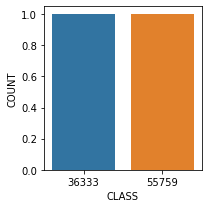

In [141]:
fig, ax = plt.subplots(figsize=(3,3))
sns.countplot(x=df_target_ohe.UNABLE_TO_DETERMINE.value_counts())
ax.set_xlabel('CLASS')
ax.set_ylabel('COUNT')

## FEATURE SELECTION

Since we're dealing with a remarkably large dataset with 102 features, we're going to process our features
by removing irrelevant and redundant data in order to reduce computation time and improve learning accuracy.

In [432]:
alphas = np.logspace(-3, -1, 100)
lasso = LassoCV(alphas=alphas, max_iter=100_000, n_jobs=6, random_state=264, cv=5)
sfm = SelectFromModel(lasso, threshold=0.0001)
sfm.fit_transform(df_features_ohe, np.ravel(np.array(df_target_ohe['UNABLE_TO_DETERMINE'])))
feature_selection_col = df_features_ohe.columns[sfm.get_support()]

In [142]:
X = df_features_ohe #[feature_selection_col]
y = np.ravel(np.array(df_target_ohe['UNABLE_TO_DETERMINE']))
print(f"Type of Target : {type_of_target(y)}")

Type of Target : binary


In [143]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size=.25, random_state=264, stratify=y)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((69069, 102), (23023, 102), (69069,), (23023,))

In [112]:
x_train, y_train = check_X_y(x_train, y_train)

## Decision Tree

In [272]:
class_weight = get_class_weight(x_train, y_train)

In [273]:
dc_param={
    'criterion': 'entropy',
    'class_weight': class_weight,
    'random_state': 264
}

In [199]:
joblib.dump(dc_param, './pkl/DecisionTree_params.pkl')

['./pkl/DecisionTree_params.pkl']

In [274]:
cls_tree = DecisionTreeClassifier(**dc_param)

In [278]:
cls_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight={0.0: 0.8258088428704656,
                                     1.0: 1.2673211009174312},
                       criterion='entropy', random_state=264)

In [297]:
model1_y_train_pred = model_metric(cls_tree, x_train, y_train)

ROC_AUC SCORE   0.7376198010166575
ACCURACY SCORE  0.7403610881871752


## Random Forest

In [298]:
cls_rf = RandomForestClassifier(class_weight=class_weight, n_jobs=6, random_state=264)

In [299]:
cls_rf.fit(x_train, np.ravel(np.array(y_train)))

RandomForestClassifier(class_weight={0.0: 0.8258088428704656,
                                     1.0: 1.2673211009174312},
                       n_jobs=6, random_state=264)

In [300]:
model2_y_train_pred = model_metric(cls_rf, x_train, y_train)

ROC_AUC SCORE   0.7360246988386605
ACCURACY SCORE  0.7416496546931329


## RandomForestClassifier: Hyperparameters with GridSearchCV

In [146]:
rfc_params = {
    'n_estimators': [2000],
    'criterion': ['gini', 'entropy'],
    'max_depth': [150],
    'max_features': [30],
    'bootstrap': [True],
    'oob_score': [True],
    'n_jobs': [6],
    'class_weight': [class_weight],
    'random_state': [264]
}

In [147]:
joblib.dump(rfc_params, './pkl/RandomForest_params.pkl')

['./pkl/RandomForest_params.pkl']

In [585]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=1, random_state=264)

In [588]:
grid_search = GridSearchCV(cls_rf, param_grid=rfc_params, scoring='roc_auc', n_jobs=6, cv=cv)

In [589]:
grid_search.fit(x_train, np.ravel(np.array(y_train)))

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=1, n_splits=10, random_state=264),
             estimator=RandomForestClassifier(class_weight={0.0: 0.8258088428704656,
                                                            1.0: 1.2673211009174312},
                                              n_jobs=6, random_state=264),
             n_jobs=6,
             param_grid={'bootstrap': [True],
                         'class_weight': [{0.0: 0.8258088428704656,
                                           1.0: 1.2673211009174312}],
                         'criterion': ['gini', 'entropy'], 'max_depth': [150],
                         'max_features': [30], 'n_estimators': [2000],
                         'n_jobs': [6], 'oob_score': [True],
                         'random_state': [264]},
             scoring='roc_auc')

In [698]:
rf_best_params=grid_search.best_params_

In [204]:
joblib.dump(rf_best_params, './pkl/RF_Grid_Search_best_params.pkl', compress=9)

['./pkl/RF_Grid_Search_best_params.pkl']

In [144]:
rf_best_params = joblib.load('./pkl/RF_Grid_Search_best_params.pkl')

In [148]:
cls_rf = RandomForestClassifier(**rf_best_params)

In [149]:
model3_train = cls_rf.fit(x_train, y_train)

In [150]:
model3_y_train_pred = model_metric(cls_rf, x_train, y_train)

ROC_AUC SCORE   0.7365930367018547
ACCURACY SCORE  0.7423301336344814


In [309]:
joblib.dump(model3_y_train_pred, './pkl/model3_y_train_predicted.pkl')

['./pkl/model3_y_train_predicted.pkl']

### TARGET PREDICTION

In [151]:
model3_test = cls_rf.fit(x_test, y_test)

In [307]:
model3_y_test_pred = model_metric(cls_rf, x_test, y_test)

ROC_AUC SCORE   0.7728139273851178
ACCURACY SCORE  0.7803500846979108


In [308]:
joblib.dump(model3_y_test_pred, './pkl/model3_y_test_predicted.pkl')

['./pkl/model3_y_test_predicted.pkl']

In [152]:
Features_importance_df = pd.DataFrame({'Features': x_train.columns,
                          'Ranking':cls_rf.feature_importances_}).sort_values(by='Ranking',ascending=False)

Features_importance_df['Ranking'] = Features_importance_df['Ranking'].apply(lambda x: x*100)

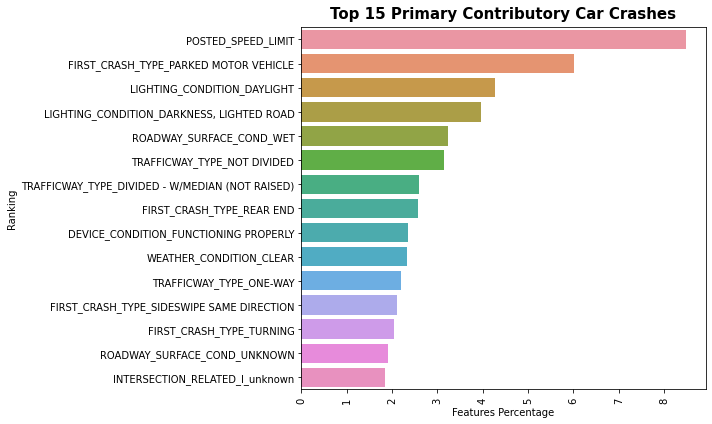

In [154]:
fig, ax = plt.subplots(figsize=(10,6))
g = sns.barplot(x='Ranking', y='Features', data=Features_importance_df.head(15))
plt.xticks(rotation=90)
ax.set_title("Top 15 Primary Contributory Car Crashes", fontsize=15, weight='bold', ha='center', va='bottom')

ax.set_xlabel('Features Percentage')
ax.set_ylabel('Ranking')
plt.savefig('./img/Y_primary_contributory_crashes.jpg',format="jpg")
plt.show()

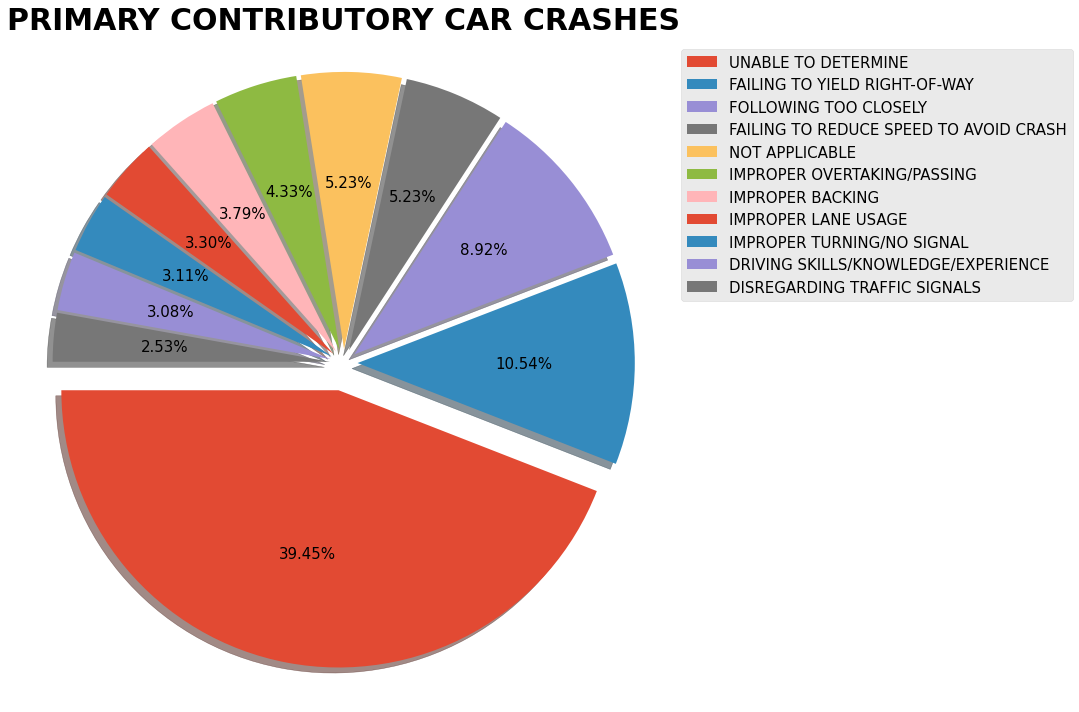

In [159]:
pcc = df_features.PRIM_CONTRIBUTORY_CAUSE.value_counts(normalize=True).apply(lambda x:x*100).sort_values(ascending=False)
pcc=pcc[pcc>=2]

labels = pcc.index
sizes  = pcc.values
explode = pcc.apply(lambda x:0.05)
explode[0]=0.1
# explode = pcc.apply(lambda x:0.2 if x > 20 else 0)
plt.style.use('ggplot')
fig1, ax1 = plt.subplots(figsize=(15,10))
ax1.pie(x=sizes, explode=explode,
        autopct=lambda v:'{p:.2f}%'.format(p=round(v/100*sizes.sum(),2)),
        shadow=True,
        startangle=180,
        textprops={'fontsize': 15})
ax1.axis('equal')  
plt.legend(labels, loc='upper left', bbox_to_anchor=(1, 1), fontsize=15)
ax1.set_title("PRIMARY CONTRIBUTORY CAR CRASHES", fontsize=30, weight='bold', ha='center', va='bottom')
plt.savefig('./img/top_15_contributory.jpg', format="jpg")
plt.show()

## Interpreting Data

Based on the data, 40% of accidents in the year 2020 are "UN ABLE TO DETERMINE", followed by "FAILING TO YIELD THE RIGHT-OF-WAY" and "FOLLOWING TO CLOSELY" which represent 10% and 9% respectively.

According to our classification model, the road accidents that seem to occur the most are caused by the speeding where the posted speed limit is 30mph.

Random Forest Model predicts car crashes with 78% accuracy even dealing with a multiclass imbalanced dataset. the accuracy score between the 2 models (training model 74.23% - test model 78.03%)  are too close which indicates that we avoided over-fitting 